In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from oggm import utils
import xarray as xr

# Reference data

In [27]:
dfz = pd.read_csv(utils.get_demo_file('zemp_ref_2006_2016.csv'), index_col=0)
dfh = pd.read_csv(utils.get_demo_file('table_hugonnet_regions_10yr_20yr_ar6period.csv'))
dfh = dfh.loc[dfh.period == '2006-01-01_2019-01-01'].set_index('reg')

In [28]:
dfz['SMB_ZEMP'] = dfz['SMB'] * 1000
dfz['SMB_ZEMP_err'] = dfz['SMB_err'] * 1000
dfz['SMB_HUGUONNET'] = dfh['dmdtda']
dfz['SMB_HUGUONNET_err'] = dfh['err_dmdtda']
dfz.index = ['{:02d}'.format(rgi_reg) for rgi_reg in dfz.index]

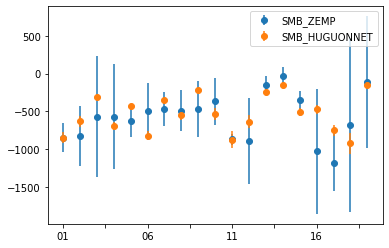

In [29]:
f, ax = plt.subplots()
dfz.plot(ax=ax, y='SMB_ZEMP', yerr='SMB_ZEMP_err', marker='o', linestyle='none');
dfz.plot(ax=ax, y='SMB_HUGUONNET', yerr='SMB_HUGUONNET_err', marker='o', linestyle='none');

## Fixed geometry SMB after calibration 

In [30]:
exp = 'era5_eb_nocalv_prepro'

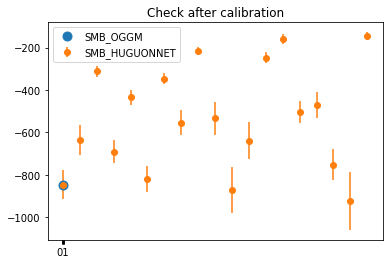

In [42]:
odir = exp + '/RGI62/b_080/L3/summary/'
    
dfz['SMB_OGGM'] = np.NaN
dfz['SMB_OGGM_calv'] = np.NaN

for rgi_reg in np.arange(1, 20):
    rgi_reg = '{:02d}'.format(rgi_reg)

    try:
        df = pd.read_csv(odir+'fixed_geometry_mass_balance_{}.csv'.format(rgi_reg), index_col=0, low_memory=False)
        dfs = pd.read_csv(odir+'glacier_statistics_{}.csv'.format(rgi_reg), index_col=0, low_memory=False)
    except FileNotFoundError: 
        print(exp, rgi_reg, 'MISSING')
        continue

    df = df.dropna(axis=0, how='all')
    df = df.dropna(axis=1, how='all')

    odf = pd.DataFrame(df.loc[2006:].mean(), columns=['SMB'])
    odf['AREA'] = dfs.rgi_area_km2
    dfz.loc[rgi_reg, 'SMB_OGGM'] = np.average(odf['SMB'], weights=odf['AREA'])

f, ax = plt.subplots()
dfz.plot(ax=ax, y='SMB_OGGM', marker='o', linestyle='none', markersize=9);
dfz.plot(ax=ax, y='SMB_HUGUONNET', yerr='SMB_HUGUONNET_err', marker='o', linestyle='none');
plt.title('Check after calibration');

## Analysis of the regional bias corrections 

In [21]:
odfs = pd.DataFrame()
for rgi_reg in np.arange(1, 20):
    rgi_reg = '{:02d}'.format(rgi_reg)
    dfs = pd.read_csv('era5_eb_nocalv_prepro/RGI62/b_080/L3/summary/glacier_statistics_{}.csv'.format(rgi_reg), index_col=0, low_memory=False)    
    odfs.loc[rgi_reg, 'avg_bias_before_corr'] = dfs.mb_bias_before_geodetic_corr.mean()
    odfs.loc[rgi_reg, 'avg_bias_after_corr'] = dfs.mb_bias.mean()
    odfs.loc[rgi_reg, 'bias_corr'] = (dfs.mb_bias.iloc[0] - dfs.mb_bias_before_geodetic_corr.iloc[0])

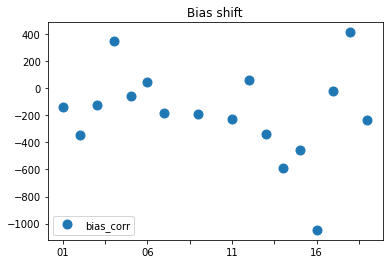

In [22]:
f, ax = plt.subplots()
odfs.plot(ax=ax, y='bias_corr', marker='o', linestyle='none', markersize=9);
plt.title('Bias shift');

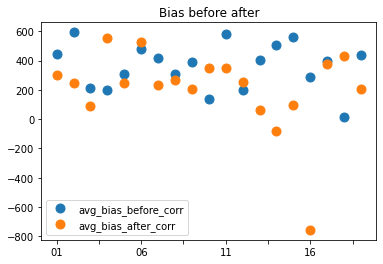

In [23]:
f, ax = plt.subplots()
odfs.plot(ax=ax, y='avg_bias_before_corr', marker='o', linestyle='none', markersize=9);
odfs.plot(ax=ax, y='avg_bias_after_corr', marker='o', linestyle='none', markersize=9);
plt.title('Bias before after');

# Now compare the SMB of the dynamics run, which is not perfect anymore

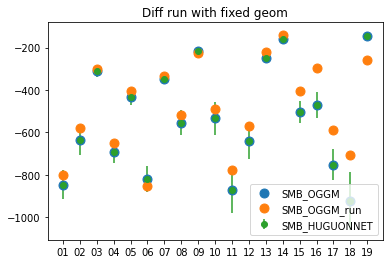

In [25]:
odir = exp + '/RGI62/b_080/L5/summary/'

for rgi_reg in np.arange(1, 20):
    rgi_reg = '{:02d}'.format(rgi_reg)
    f = odir + 'historical_run_output_extended_{}.nc'.format(rgi_reg)
    with xr.open_dataset(f) as ds:
        ds = ds.sel(time=slice(2006, None))
        area = ds.area_ext.isel(time=0)
        area = area.where(area > 0)
        dmdtda = (ds.volume_ext.isel(time=-1) - ds.volume_ext.isel(time=0)) / area / len(ds.time) * 900

        dfz.loc[rgi_reg, 'SMB_OGGM_run'] = np.average(dmdtda.dropna(dim='rgi_id'), weights=area.dropna(dim='rgi_id')) 

f, ax = plt.subplots()
dfz.plot(ax=ax, y='SMB_OGGM', marker='o', linestyle='none', markersize=9);
dfz.plot(ax=ax, y='SMB_OGGM_run', marker='o', linestyle='none', markersize=9);
dfz.plot(ax=ax, y='SMB_HUGUONNET', yerr='SMB_HUGUONNET_err', marker='o', linestyle='none');
plt.xticks(range(0, len(dfz.index)), labels=dfz.index);
plt.title('Diff run with fixed geom');